# Collecting and Using Data in Python

## Laila A. Wahedi
### Massive Data Institute Postdoctoral Fellow <br>McCourt School of Public Policy<br>

### Follow along: Wahedi.us, Current Presentation

# Agenda for today:
* More on manipulating data
* Scrape data
* Merge data into a data frame 
* Run a basic model on the data

# Packages to Import For Today
* Should all be included with your Anaconda Python Distribution
 * Raise your hand for help if you have trouble
* Our plots will use matplotlib, similar to plotting in matlab
* %matplotlib inline tells Jupyter Notebooks to display your plots
* from allows you to import part of a package

In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import time
# from ggplot import *

/home/law98/anaconda/envs/p3env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Other Useful Packages (not used today)
* ggplot: the familiar ggplot2 you know and love from R
* seaborn: Makes your plots prettier
* plotly: makes interactive visualizations, similar to shiny
* gensim: package for doing natural language processing
* scipy: used with numpy to do math. Generates random numbers from distributions, does matrix operations, etc. 

# Data Manipulation 

* Download the .csv file at: <br>
https://data.chhs.ca.gov/dataset/asthma-emergency-department-visit-rates-by-zip-code
  * OR: https://tinyurl.com/y79jbxlk
* Move it to the same directory as your notebook

In [10]:
asthma_data = pd.read_csv('asthma-emergency-department-visit-rates-by-zip-code.csv')
asthma_data.head()

,Year,ZIP code,Age Group,Number of Visits,Age-adjusted rate,County Fips code,County
0,2015,"90004\n(34.07646, -118.309453)",Children (0-17),117.0,91.7,6037,LOS ANGELES
1,2015,"90011\n(34.007055, -118.258872)",Children (0-17),381.0,102.8,6037,LOS ANGELES
2,2015,"90002\n(33.949079, -118.247877)",Children (0-17),227.0,123.8,6037,LOS ANGELES
3,2013,"90004\n(34.07646, -118.309453)",Children (0-17),169.0,129.4,6037,LOS ANGELES
4,2014,"90012\n(34.064406, -118.239532)",Children (0-17),22.0,69.1,6037,LOS ANGELES


### Look at those zip codes!

# Clean Zip Code
* We don't need the latitude and longitude
* Create two variables by splitting the zip code variable: 
    * index the data frame to the zip code variable
    * split it in two: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.split.html
    * assign it to another two variables
* Remember: can't run this cell twice without starting over

In [12]:
asthma_data[['zip','coordinates']] = asthma_data.loc[:,'ZIP code'].str.split(
                                                        pat='\n',expand=True)
asthma_data.drop('ZIP code', axis=1,inplace=True)
asthma_data.head(2)

,Year,Age Group,Number of Visits,Age-adjusted rate,County Fips code,County,zip,coordinates
0,2015,Children (0-17),117.0,91.7,6037,LOS ANGELES,90004,"(34.07646, -118.309453)"
1,2015,Children (0-17),381.0,102.8,6037,LOS ANGELES,90011,"(34.007055, -118.258872)"


# Rearrange The Data: Group By
* Make child and adult separate columns rather than rows. 
* Must specify how to aggregate the columns <br>
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html


In [5]:
asthma_grouped = asthma_data.groupby(by=['Year','zip']).sum()
asthma_grouped.head(4)

Number of Visits  Age-adjusted rate  County Fips code
Year zip                                                         
2009 90001             818.0         226.074245             18111
     90002             836.0         265.349315             18111
     90003            1542.0         369.202131             18111
     90004             580.0         145.538276             18111

### Lost Columns!  Fips summed!

# Group by: Cleaning Up
 * Lost columns you can't sum
 * took sum of fips
 * Must add these back in
 * Works because temp table has same index

In [43]:
asthma_grouped.drop('County Fips code',axis=1,inplace=True)
temp_grp = asthma_data.groupby(by=['Year','zip']).first()
asthma_grouped[['fips','county','coordinates']]=temp_grp.loc[:,['County Fips code',
                                                                'County',
                                                                'coordinates']]
asthma_grouped.loc[:,'Number of Visits']=asthma_grouped.loc[:,'Number of Visits']/2
asthma_grouped.head(2)

Number of Visits  Age-adjusted rate  fips       county  \
Year zip                                                             
2009 90001             409.0         226.074245  6037  LOS ANGELES   
     90002             418.0         265.349315  6037  LOS ANGELES   

                         coordinates  
Year zip                              
2009 90001  (33.973252, -118.249154)  
     90002  (33.949079, -118.247877)

# Aside on Copying
* Multiple variables can point to the same data in Python. Saves memory
* If you set one variable equal to another, then change the first variable, the second changes.
* Causes warnings in Pandas all the time. 
* Solution: 
 * Use proper slicing-- .loc[] --for the right hand side
 * Use copy


In [60]:
A = [5]
B = A
A.append(6)
print(B)

[5, 6]


In [61]:
import copy
A = [5]
B = A.copy()
A.append(6)
print(B)

[5]


In [62]:
asthma_grouped[['fips','county','coordinates']]=temp_grp.loc[:,['County Fips code',
                                                                'County',
                                                                'coordinates']].copy()

# Rearrange The Data: Pivot
* Use pivot and melt to to move from row identifiers to column identifiers and back <br>
https://pandas.pydata.org/pandas-docs/stable/reshaping.html#reshaping-by-melt
* Tell computer what to do with every cell:
 * Index: Stays the same
 * Columns: The column containing the new column labels
 * Values: The column containing values to insert
<img src='pivot.png'>

# Rearrange The Data: Pivot
* Tell computer what to do with every cell:
 * Index: Stays the same
 * Columns: The column containing the new column labels
 * Values: The column containing values to insert


In [48]:
asthma_unstacked = asthma_data.pivot_table(index = ['Year',
                                                    'zip',
                                                    'County',
                                                    'coordinates',
                                                    'County Fips code'], 
                                           columns = 'Age Group', 
                                           values = 'Number of Visits')
asthma_unstacked.reset_index(drop=False,inplace=True)
asthma_unstacked.head(2)

Age Group,Year,zip,County,coordinates,County Fips code,Adults (18+),All Ages,Children (0-17)
0,2009,90001,LOS ANGELES,"(33.973252, -118.249154)",6037,206.0,409.0,203.0
1,2009,90002,LOS ANGELES,"(33.949079, -118.247877)",6037,204.0,418.0,214.0


# Rename Columns, Subset Data

In [49]:
asthma_unstacked.rename(columns={
    'zip':'Zip',
    'coordinates':'Coordinates',
    'County Fips code':'Fips',
    'Adults (18+)':'Adults',
    'All Ages':'Incidents',
    'Children (0-17)': 'Children'
    },
    inplace=True)
asthma_2015 = asthma_unstacked.loc[asthma_unstacked.Year==2015,:]
asthma_2015.head(2)

Age Group,Year,Zip,County,Coordinates,Fips,Adults,Incidents,Children
4693,2015,90001,LOS ANGELES,"(33.973252, -118.249154)",6037,229.0,441.0,212.0
4694,2015,90002,LOS ANGELES,"(33.949079, -118.247877)",6037,249.0,476.0,227.0


# Save Your Data
* No saving your workspace like in R or STATA
* Save specific variables, models, or results using Pickle
 * wb: write binary. Tells computer to save the file
 * rb: read binary. Tells computer to read the file
 * If you mix them up, you may write over your data and lose it
* Write your data to a text file to read later

In [287]:
pickle.dump(asthma_unstacked,open('asthma_unstacked.p','wb'))
asthma_unstacked.to_csv('asthma_unstacked.csv')

In [288]:
asthma_unstacked = pickle.load(open('asthma_unstacked.p','rb'))

# Scraping


# How the Internet Works

* Code is stored on servers
* Web addresses point to the location of that code 


1. Going to an address or clicking a button sends requests to the server for data, 
2. The server returns the requested content
3. Your web browser interprets the code to render the web page 

<img src='Internet.png'>

# Scraping: 
* Collect the website code by emulating the process:
  * Can haz cheezburger?
  <img src='burger.png'>
* Extract the useful information from the scraped code:
  * Where's the beef? 
  <img src='beef.png'>

# API
### Application Programming Interface 
* The set of rules that govern communication between two pieces of code
* Code requires clear expected inputs and outputs
* APIs define required inputs to get the outputs in a format you can expect. 
* Easier than scraping a website because gives you exactly what you ask for

<img src = "beef_direct.png">

# API Keys
## APIs often require identification
* Go to https://docs.airnowapi.org 
* Register and get a key
* Log in to the site
* Select web services

## DO NOT SHARE YOUR KEY
* It will get stolen and used for malicious activity

# Requests to a Server


<div style="float: left;width:50%">
<h3> GET</h3>
<ul><li>Requests data from the server</li>
<li> Encoded into the URL</li></ul>
<img src = 'get.png'>
</div>
<div style="float: left;width:50%">
<h3>POST</h3>
<ul><li>Submits data to be processed by the server</li>
<li>For example, filter the data</li>
<li>Can attach additional data not directly in the url</li></ul>
<img src = 'post.png'>
</div>

# Using an API
<img src = 'api.png'>

# Requests encoded in the URL
### Parsing a URL

### <font color="blue">http://www.airnowapi.org/aq/observation/zipCode/historical/</font><font color="red">?</font><br><font color="green">format</font>=<font color="purple">application/json</font><font color="orange">&<br></font><font color="green">zipCode</font>=<font color="purple">20007</font><font color="orange">&</font><br><font color="green">date</font>=<font color="purple">2017-09-05T00-0000</font><font color="orange">&</font><br><font color="green">distance</font>=<font color="purple">25</font><font color="orange">&</font><br><font color="green">API_KEY</font>=<font color="purple">D9AA91E7-070D-4221-867CC-XXXXXXXXXXX</font>

* The base URL or endpoint is:<br>
<font color="blue">http://www.airnowapi.org/aq/observation/zipCode/historical/</font>

* <font color="red">?</font> tells us that this is a query. 
* <font color="orange">&</font> separates name, value pairs within the request.

* Five <font color="green"><strong>name</strong></font>, <font color="purple"><strong>value</strong></font> pairs POSTED 
 * format, zipCode, date, distance, API_KEY

# Request from Python
### prepare the url
* List of attributes
* Join them with "&" to form a string

In [19]:
base_url = "http://www.airnowapi.org/aq/observation/zipCode/historical/"
attributes = ["format=application/json",
            "zipCode=20007",
            "date=2017-09-05T00-0000",
            "distance=25",
            "API_KEY=39DC3727-09BD-48C4-BBD8-XXXXXXXXXXXX"
             ]
post_url = '&'.join(attributes)
print(post_url)

format=application/json&zipCode=20007&date=2017-09-05T00-0000&distance=25&API_KEY=39DC3727-09BD-48C4-BBD8-XXXXXXXXXXXX


# Requests from Python
* Use requests package
* Requested json format
    * Returns list of dictionaries
    * Look at the returned keys

In [17]:
ingredients=requests.get(base_url, post_url)
ingredients = ingredients.json()
print(ingredients[0])

{'DateObserved': '2017-09-05 ', 'HourObserved': 0, 'LocalTimeZone': 'EST', 'ReportingArea': 'Metropolitan Washington', 'StateCode': 'DC', 'Latitude': 38.919, 'Longitude': -77.013, 'ParameterName': 'OZONE', 'AQI': 47, 'Category': {'Number': 1, 'Name': 'Good'}}


# View Returned Data:
* Each list gives a different parameter for zip code and date we searched

In [18]:
for item in ingredients:
           AQIType = item['ParameterName']
           City=item['ReportingArea']
           AQIValue=item['AQI']
           print("For Location ", City, " the AQI for ", AQIType, "is ", AQIValue)

For Location  Metropolitan Washington  the AQI for  OZONE is  47
For Location  Metropolitan Washington  the AQI for  PM2.5 is  61
For Location  Metropolitan Washington  the AQI for  PM10 is  13


# Ethics
* Check the websites terms of use
* Don't hit too hard:
    * Insert pauses in your code to act more like a human
    * Scraping can look like an attack
    * Server will block you without pauses
* APIs often have rate limits
* Use the time package to pause for a second between hits

In [ ]:
time.sleep(1)

# Collect Our Data
### Python helps us automate repetitive tasks. Don't download each datapoint you want separately
* Get a list of zip codes we want
 * take a subset to demo, so it doesn't take too long and so we don't all hit too hard from the same ip
* Request the data for those zipcodes on a day in 2015 (you pick, fire season July-Oct)
 * Be sure to sleep between requests
* Store that data as you go into a dictionary
 * Key: zip code
 * Value: Dictionary of the air quality parameters and their value

In [ ]:
base_url = "http://www.airnowapi.org/aq/observation/zipCode/historical/"
zips = asthma_2015.Zip.unique()
zips = zips[:450]
date ="date=2015-09-01T00-0000"
api_key = "API_KEY=39DC3727-09BD-48C4-BBD8-XXXXXXXXXXXX"
return_format = "format=application/json"
zip_str = "zipCode="
post_url = "&".join([date,api_key,return_format,zip_str])
data_dict = {}
for zipcode in zips:
    time.sleep(1)
    zip_post = post_url + str(zipcode)
    ingredients = requests.get(base_url, zip_post)
    ingredients = ingredients.json()
    zip_data = {}
    for data_point in ingredients:
        AQIType = data_point['ParameterName']
        AQIVal = data_point['AQI']
        zip_data[AQIType] = AQIVal
    data_dict[zipcode]= zip_data

# Scraping: Parsing HTML
* What about when you don't have an API that returns dictionaries?
* HTML is a markup language that displays data (text, images, etc)
* Puts content within nested tags to tell your browser how to display it

***

### &lt;Section_tag>
### &emsp; &lt;tag> Content &lt;/tag>
### &emsp; &lt;tag> Content &lt;/tag>
### &lt; /Section_tag>
### &lt;Section_tag>
### &emsp; &lt;tag> <font color="red">Beef</font> &lt;/tag>
### &lt; /Section_tag>

# Find the tags that identify the content you want:
* First paragraph of wikipedia article: 
https://en.wikipedia.org/wiki/Data_science
* Inspect the webpage: 
 * Windows: ctrl+shift+i
 * Mac: ctrl+alt+i
 
<img src = "wikipedia_scrape.png">


# Parsing HTML with Beautiful Soup
### Beautiful Soup takes the raw html and parses the tags so you can search through them. 
* text attribute returns raw html text from requests
* Ignore the warning, default parser is fine
* We know it's the first paragraph tag in the body tag, so: 
 * Can find first tag of a type using <strong>.</strong>
* But it's not usually that easy...

In [21]:
ingredients = requests.get("https://en.wikipedia.org/wiki/Data_science")
soup = bs(ingredients.text)
print(soup.body.p)

<p><b>Data science</b>, also known as <b>data-driven science</b>, is an interdisciplinary field of scientific methods, processes, and systems to extract <a href="/wiki/Knowledge" title="Knowledge">knowledge</a> or insights from <a href="/wiki/Data" title="Data">data</a> in various forms, either structured or unstructured,<sup class="reference" id="cite_ref-:0_1-0"><a href="#cite_note-:0-1">[1]</a></sup><sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup> similar to <a href="/wiki/Data_mining" title="Data mining">data mining</a>.</p>


# Use Find Feature to Narrow Your Search
* Find the unique div we identified
 * Remember the underscore: "class_"
* Find the p tag within the resulting html
* Use an index to return just the first paragraph tag
* Use the text attribute to ignore all the formatting and link tags
* Next: Use a for loop and scrape the first paragraph from a bunch of wikipedia articles
* Learn More: http://web.stanford.edu/~zlotnick/TextAsData/Web_Scraping_with_Beautiful_Soup.html

In [23]:
parser_div = soup.find("div", class_="mw-parser-output")
wiki_content = parser_div.find_all('p')
print(wiki_content[0])
print('*****************************************')
print(wiki_content[0].text)

<p><b>Data science</b>, also known as <b>data-driven science</b>, is an interdisciplinary field of scientific methods, processes, and systems to extract <a href="/wiki/Knowledge" title="Knowledge">knowledge</a> or insights from <a href="/wiki/Data" title="Data">data</a> in various forms, either structured or unstructured,<sup class="reference" id="cite_ref-:0_1-0"><a href="#cite_note-:0-1">[1]</a></sup><sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup> similar to <a href="/wiki/Data_mining" title="Data mining">data mining</a>.</p>
*****************************************
Data science, also known as data-driven science, is an interdisciplinary field of scientific methods, processes, and systems to extract knowledge or insights from data in various forms, either structured or unstructured,[1][2] similar to data mining.


# Back To Our Data
* If it's still running, go ahead and stop it by pushing the square at the top of the notebook: 
<img src="interrupt.png">
* Save what you collected, don't want to hit them twice!

In [306]:
pickle.dump(data_dict,open('AQI_data_raw.p','wb'))

# Subset down to the data we have:
* use the isin() method to include only those zip codes we've already collected

In [307]:
collected = list(data_dict.keys())
asthma_2015_sub = asthma_2015.loc[asthma_2015.Zip.isin(collected),:]

# Create a dataframe from the new AQI data

In [308]:
aqi_data = pd.DataFrame.from_dict(data_dict, orient='index')
aqi_data.reset_index(drop=False,inplace=True)
aqi_data.rename(columns={'index':'Zip'},inplace=True)
aqi_data.head()

,Zip,OZONE,PM2.5,PM10
0,90001,36.0,NaN,NaN
1,90002,36.0,NaN,NaN
2,90003,36.0,NaN,NaN
3,90004,54.0,NaN,NaN
4,90005,54.0,NaN,NaN


# Combine The Data
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html
* Types of merges:
 * Left: Use only rows from the dataframe you are merging into
 * Right: use only rows from the dataframe you are inserting, (the one in the parentheses)
 * Inner: Use only rows that match between both
 * Outer: Use all rows, even if they only appear in one of the dataframes
* On: The variables you want to compare
 * Specify right_on and left_on if they have different names

In [309]:
asthma_aqi = asthma_2015_sub.merge(aqi_data,how='outer',on='Zip')
asthma_aqi.head(2)

,Year,Zip,County,Coordinates,Fips,Adults,Incidents,Children,OZONE,PM2.5,PM10
0,2015,90001,LOS ANGELES,"(33.973252, -118.249154)",6037,229.0,441.0,212.0,36.0,NaN,NaN
1,2015,90002,LOS ANGELES,"(33.949079, -118.247877)",6037,249.0,476.0,227.0,36.0,NaN,NaN


# Look At The Data: Histogram
* 20 bins

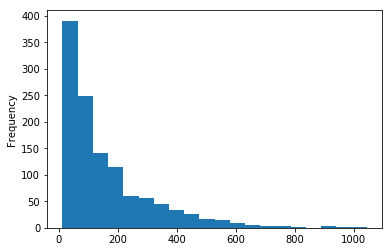

In [310]:
asthma_aqi.Incidents.plot.hist(20)

# Look At The Data: Smoothed Distribution

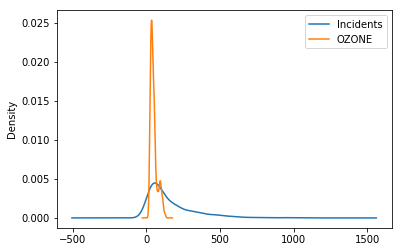

In [311]:
asthma_aqi.loc[:,['Incidents','OZONE']].plot.density()

# Look at particulates
* There is a lot of missingness in 2015
* Try other variables, such as comparing children and adults

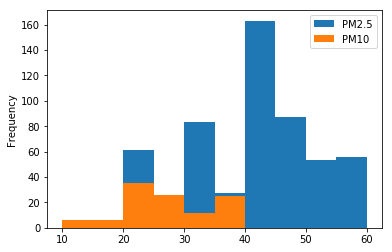

In [312]:
asthma_aqi.loc[:,['PM2.5','PM10']].plot.hist()

# Scatter Plot
* Try some other combinations
* Our data look clustered, but we'll ignore that for now

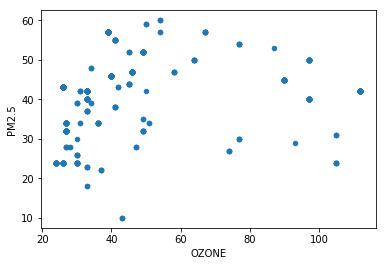

In [327]:
asthma_aqi.plot.scatter('OZONE','PM2.5')

# Run a regression:
* Note: statsmodels supports equation format like R <br>
http://www.statsmodels.org/dev/example_formulas.html

In [320]:
y =asthma_aqi.loc[:,'Incidents']
x =asthma_aqi.loc[:,['OZONE','PM2.5']]
x['c'] = 1
ols_model1 = sm.OLS(y,x,missing='drop')
results = ols_model1.fit()
print(results.summary())
pickle.dump([results,ols_model1],open('ols_model_results.p','wb'))

                            OLS Regression Results                            
Dep. Variable:              Incidents   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.896
Date:                Thu, 15 Feb 2018   Prob (F-statistic):            0.00293
Time:                        10:23:19   Log-Likelihood:                -3521.4
No. Observations:                 544   AIC:                             7049.
Df Residuals:                     541   BIC:                             7062.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
OZONE          0.5115      0.266      1.923      0.0

# Clustering Algorithm
* Learn more about clustering here: <br>
http://scikit-learn.org/stable/modules/clustering.html
* Use sklearn, a package for data mining and machine learing
* Drop rows with missing values first
* Standardize the data so they're all on the same scale

In [325]:
model_df = asthma_aqi.loc[:,['OZONE','PM2.5','Incidents',]]
model_df.dropna(axis=0,inplace=True)
model_df = (model_df - model_df.mean()) / (model_df.max() - model_df.min())
asthma_air_clusters=cluster.KMeans(n_clusters = 3)
asthma_air_clusters.fit(model_df)
model_df['clusters3']=asthma_air_clusters.labels_


# Look At Clusters
* Our data are very closely clustered, OLS was probably not appropriate. 

Text(0.5,0,'Incidents')

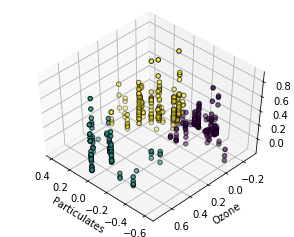

In [326]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

labels = asthma_air_clusters.labels_

ax.scatter(model_df.loc[:, 'PM2.5'], model_df.loc[:, 'OZONE'], model_df.loc[:, 'Incidents'],
           c=labels.astype(np.float), edgecolor='k')

ax.set_xlabel('Particulates')
ax.set_ylabel('Ozone')
ax.set_zlabel('Incidents')
